# COLETA DE DADOS

In [1]:
!python -V

import pandas as pd # download library to read data into dataframe
import numpy as np # import numpy library
import matplotlib.pyplot as plt # plots
from matplotlib import cm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

print("Data read into dataframe!") # takes about 30 seconds

cancer_data = pd.read_csv("data (1).csv")
cancer_data.head()

Python 3.13.0
Data read into dataframe!


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# PREPARAÇÃO DOS DADOS

In [2]:
# Codificar a variável de diagnóstico (M = 1 para Maligno, B = 0 para Benigno)
label_encoder = LabelEncoder()
cancer_data['diagnosis'] = label_encoder.fit_transform(cancer_data['diagnosis'])

# 1) Calcular as correlações das variáveis com a variável de diagnóstico
correlations = cancer_data.corr()['diagnosis'].abs().sort_values(ascending=False)
top_features = correlations[1:6].index.tolist()  # Seleciona as 5 melhores correlações (excluindo 'diagnosis' de si mesma)

# Filtrar os dados para manter apenas as colunas com maior correlação
top_data = cancer_data[['diagnosis'] + top_features]

# 2) Adaptação do código para a base de dados de câncer com as 5 melhores correlações

# Separar a variável Y (diagnosis) e as variáveis X (as 5 melhores)
Y = top_data['diagnosis']
X = top_data.drop(columns=['diagnosis'])

# Resetar o índice
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

# Ajuste das variáveis categóricas (se houver) em colunas binárias - OneHotEncoder
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

# Transformar as variáveis categóricas em colunas binárias
cat_one_hot_list = [pd.get_dummies(X[col]) for col in categorical_features]
X = pd.concat([X.drop(columns=categorical_features)] + cat_one_hot_list, axis=1)

print("As 5 variáveis com melhor correlação com 'diagnosis':", top_features)
print("Dados prontos para uso no modelo de classificação.")

As 5 variáveis com melhor correlação com 'diagnosis': ['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean']
Dados prontos para uso no modelo de classificação.


In [3]:
#Divindindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Verificar o tamanho dos conjuntos de treino e teste
print(f'Tamanho do conjunto de treino: {X_train.shape[0]} amostras')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]} amostras')


Tamanho do conjunto de treino: 426 amostras
Tamanho do conjunto de teste: 143 amostras


# MODELO - Random Forest Classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

Random Forest accuracy: 0.958041958041958
Random Forest precision: 0.9444444444444444
Random Forest recall: 0.9444444444444444
Random Forest f1: 0.9444444444444444
Random Forest roc_auc: 0.9553682896379525


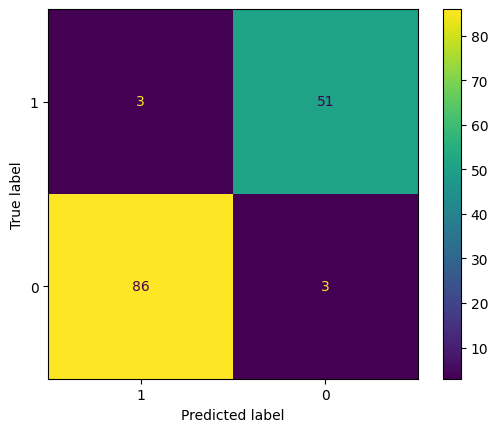

In [6]:
print(f'Random Forest accuracy: {accuracy_score(y_test,pred_rf)}')
print(f'Random Forest precision: {precision_score(y_test,pred_rf)}')
print(f'Random Forest recall: {recall_score(y_test,pred_rf)}')
print(f'Random Forest f1: {f1_score(y_test,pred_rf)}')
print(f'Random Forest roc_auc: {roc_auc_score(y_test,pred_rf)}')

cf_matrix_rf = confusion_matrix(y_test,pred_rf, labels=rf.classes_)
ConfusionMatrixDisplay(confusion_matrix=cf_matrix_rf[::-1], # [::-1] para imprimir a CM na ordem correta
                       display_labels=rf.classes_[::-1]).plot()

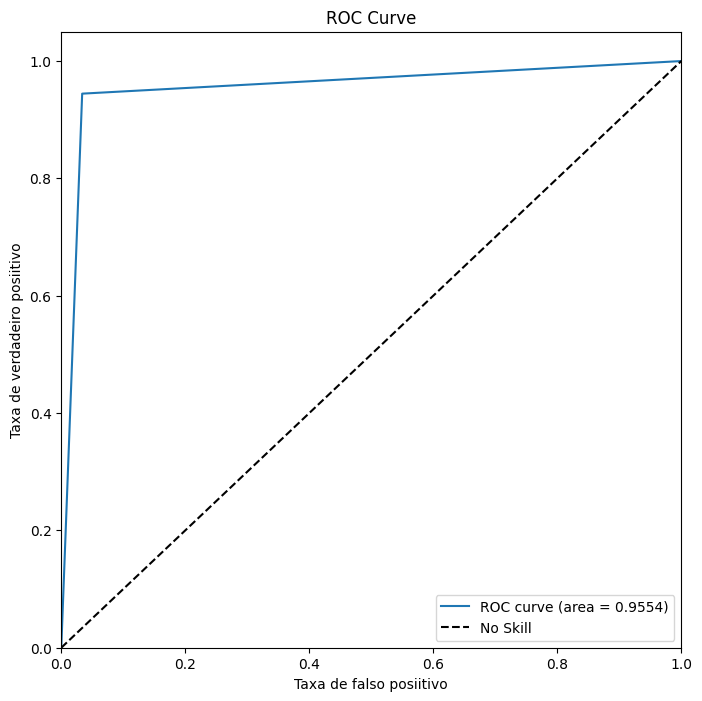

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, pred_rf) 
roc_auc = roc_auc_score(y_test,pred_rf)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--', label='No Skill')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Taxa de falso posiitivo')
ax.set_ylabel('Taxa de verdadeiro posiitivo')
plt.title('ROC Curve')
ax.legend()
plt.show()

# TENTANDO MELHORAR AS MÉTRICAS

In [8]:
# utilizamos os dois principais parametros deste método
# n_estimators é a quantidade de arvores de decisão
# max_depth é a profundidade máxima das arvores de decisão
param_grid_rf = {'n_estimators':[10,20,50,100,200,400,800],'max_depth':[2,6,10,14,18,22,26]}

In [9]:
# Initialize random forest
rf = RandomForestClassifier(n_jobs=-1, random_state=0) # n_jobs permite processamento paralelo, random_state para que o modelo não mude (modelo baseado em aleatóriedade)

metrics = ['accuracy','precision','recall','f1','roc_auc']

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid_rf, cv=5, scoring=metrics, refit=False, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [2, 6, 10, 14, 18, 22, 26],
                         'n_estimators': [10, 20, 50, 100, 200, 400, 800]},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [10]:
#To get the results of the gridsearch
grid_search.cv_results_

{'mean_fit_time': array([0.07717285, 0.09065661, 0.17802401, 0.23667984, 0.33452058,
        0.646279  , 1.36754279, 0.04040475, 0.05526433, 0.12418108,
        0.1920414 , 0.4330039 , 0.73615298, 1.48170691, 0.07914491,
        0.09921222, 0.13749161, 0.21148028, 0.43714461, 0.77524548,
        1.56558404, 0.04240341, 0.05915189, 0.11547632, 0.21711307,
        0.4175549 , 0.95314031, 1.61324844, 0.04104061, 0.05678329,
        0.11820683, 0.22144513, 0.42121372, 0.98221374, 1.68955474,
        0.04089785, 0.05520735, 0.11608911, 0.22852697, 0.42348108,
        0.92955179, 1.97455921, 0.04479189, 0.0599925 , 0.13655519,
        0.25105424, 0.56850157, 0.95725727, 2.14936509]),
 'std_fit_time': array([0.03610048, 0.04780734, 0.04067276, 0.07730232, 0.01021077,
        0.00878309, 0.03119911, 0.00164648, 0.01163786, 0.03930651,
        0.01184127, 0.10455678, 0.01424959, 0.03708296, 0.01568705,
        0.00504909, 0.03982675, 0.00681817, 0.13140041, 0.0294743 ,
        0.04437229, 0.004

In [11]:
results = {'max_depth':[],'n_estimators':[],'accuracy':[],'precision':[],'recall':[],'f1':[],'roc_auc':[]}
for i in range(len(grid_search.cv_results_['params'])):
    results['max_depth'].append(grid_search.cv_results_['params'][i]['max_depth'])
    results['n_estimators'].append(grid_search.cv_results_['params'][i]['n_estimators'])
    results['accuracy'].append(grid_search.cv_results_['mean_test_accuracy'][i])
    results['precision'].append(grid_search.cv_results_['mean_test_precision'][i])
    results['recall'].append(grid_search.cv_results_['mean_test_recall'][i])
    results['f1'].append(grid_search.cv_results_['mean_test_f1'][i])
    results['roc_auc'].append(grid_search.cv_results_['mean_test_roc_auc'][i])

results = pd.DataFrame(results)

In [12]:
results

,max_depth,n_estimators,accuracy,precision,recall,f1,roc_auc
0,2,10,0.927223,0.910806,0.892540,0.900385,0.973806
1,2,20,0.936607,0.918067,0.911694,0.914162,0.978963
2,2,50,0.938960,0.923712,0.911694,0.917029,0.981332
3,2,100,0.938960,0.923712,0.911694,0.917029,0.980507
4,2,200,0.936607,0.918067,0.911694,0.914162,0.982948
5,2,400,0.936607,0.918067,0.911694,0.914162,0.981748
6,2,800,0.936607,0.918067,0.911694,0.914162,0.981511
7,6,10,0.929603,0.916197,0.892742,0.903617,0.973591
8,6,20,0.931902,0.902616,0.918145,0.909292,0.979809
9,6,50,0.936553,0.914775,0.918145,0.915236,0.983460


In [13]:
def function_to_plot_results(results,metric):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))

    # Make data.
    Y = results['max_depth'].unique()
    X = results['n_estimators'].unique()
    XX, YY = np.meshgrid(X, Y)
    Z = results[metric].array.reshape(-1,len(X))

    # Plot the surface.
    surf = ax.plot_surface(np.log10(XX), YY, Z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 1.01)
    ax.set_xticks(np.log10(X),X)
    ax.set_yticks(Y)
    ax.set_xlabel('n_estimators',fontsize=12)
    ax.set_ylabel('max_depth',fontsize=12)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=10)

    ax.set_title(metric,fontsize=24)

    plt.show()

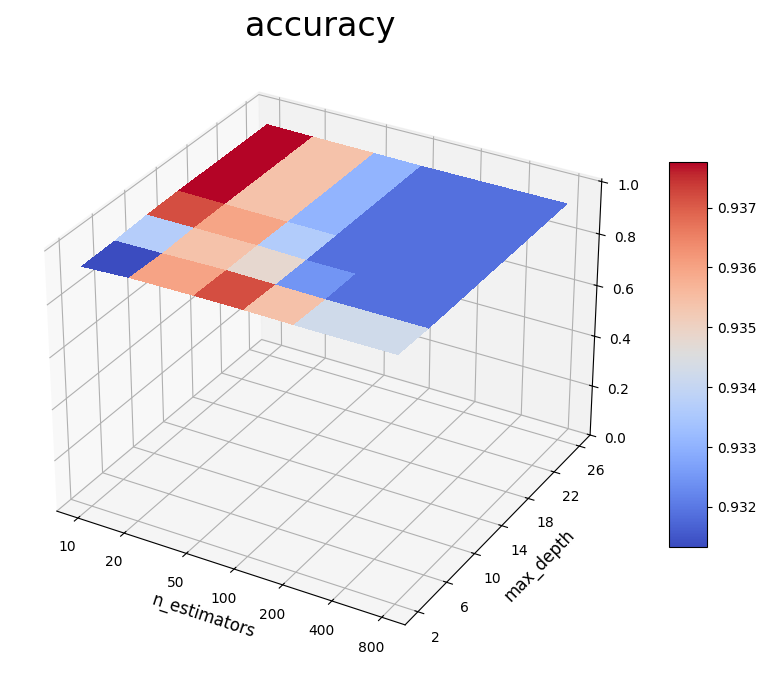

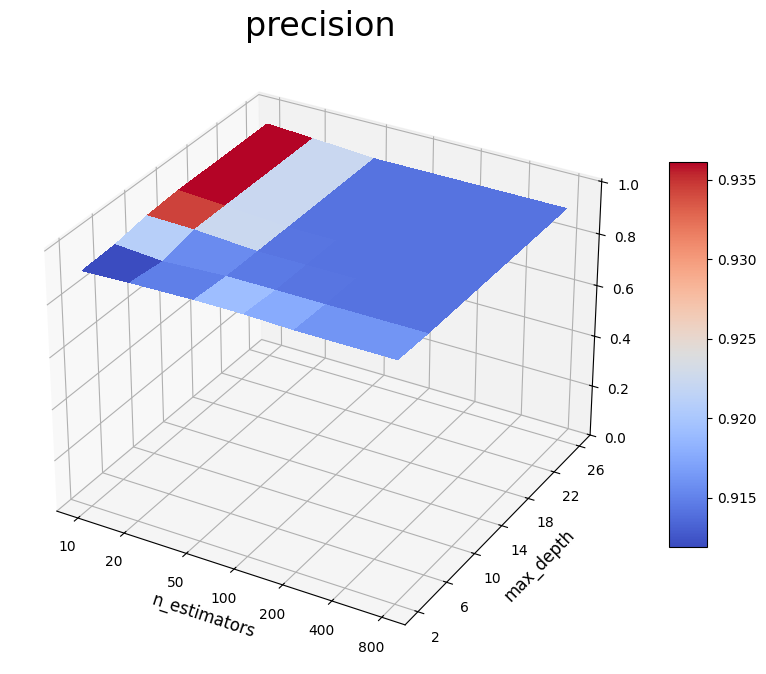

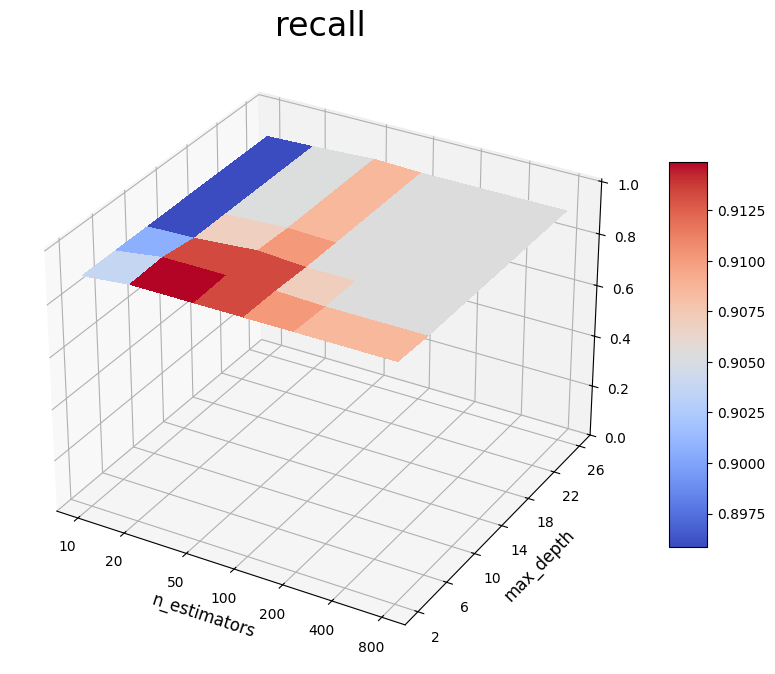

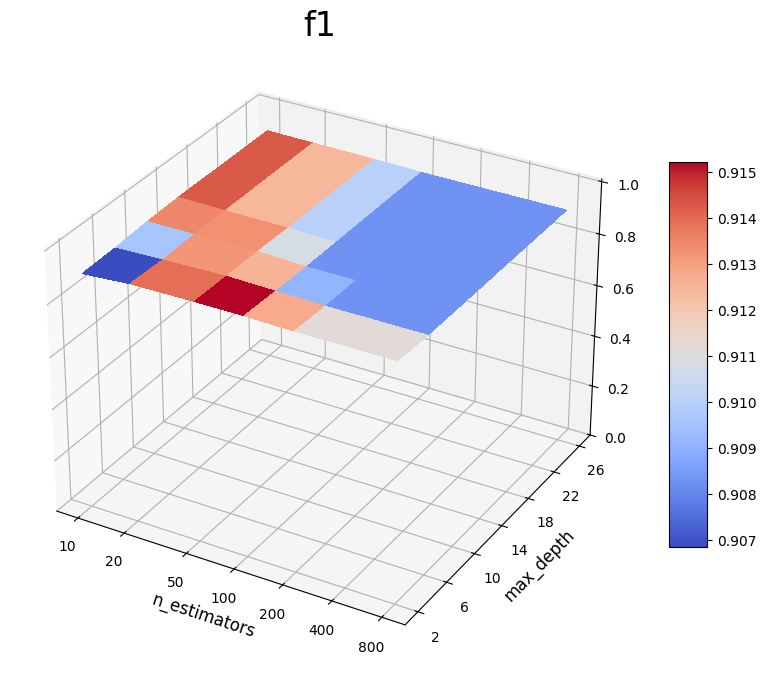

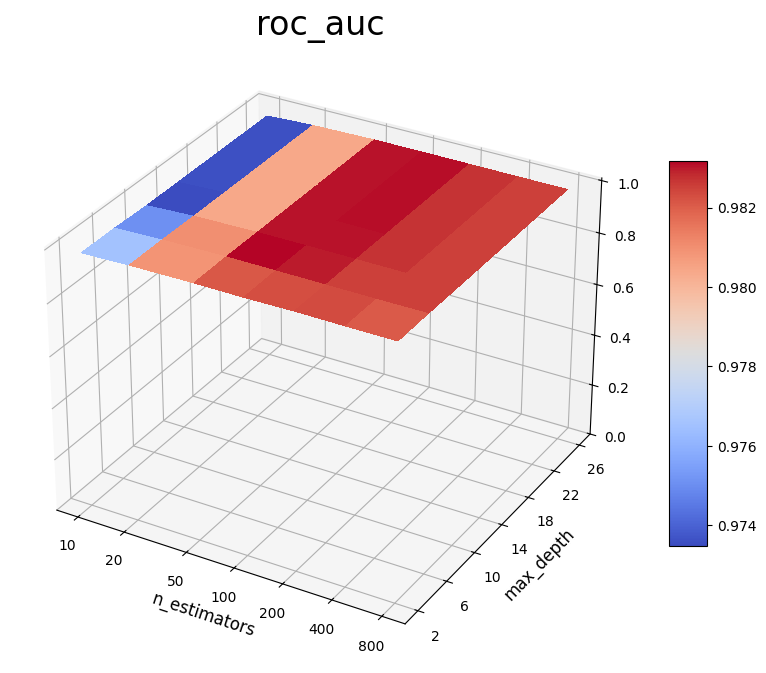

In [14]:
function_to_plot_results(results,'accuracy')
function_to_plot_results(results,'precision')
function_to_plot_results(results,'recall')
function_to_plot_results(results,'f1')
function_to_plot_results(results,'roc_auc')

In [15]:
#Melhor acurácia
print(results[['max_depth','n_estimators','accuracy']][results['accuracy'] == results['accuracy'].max()])

#Melhor precision
print(results[['max_depth','n_estimators','precision']][results['precision'] == results['precision'].max()])

#Melhor recall
print(results[['max_depth','n_estimators','recall']][results['recall'] == results['recall'].max()])

#Melhor f1
print(results[['max_depth','n_estimators','f1']][results['f1'] == results['f1'].max()])

#Melhor roc_auc
print(results[['max_depth','n_estimators','roc_auc']][results['roc_auc'] == results['roc_auc'].max()])

    max_depth  n_estimators  accuracy
2           2            50   0.93896
3           2           100   0.93896
21         14            10   0.93896
28         18            10   0.93896
35         22            10   0.93896
42         26            10   0.93896
    max_depth  n_estimators  precision
21         14            10   0.941818
28         18            10   0.941818
35         22            10   0.941818
42         26            10   0.941818
   max_depth  n_estimators    recall
8          6            20  0.918145
9          6            50  0.918145
   max_depth  n_estimators        f1
2          2            50  0.917029
3          2           100  0.917029
   max_depth  n_estimators  roc_auc
9          6            50  0.98346


In [16]:
#Nós temos dois possíveis modelos
#O que maximiza a acurácia, recall, f1, e roc_auc
rf_model_1 = RandomForestClassifier(max_depth=26,n_estimators=100,n_jobs=-1, random_state=0)
#O que maximiza a precision
rf_model_2 = RandomForestClassifier(max_depth=14,n_estimators=400,n_jobs=-1, random_state=0)

# RESULTADOS MODELOS TREINADOS

In [17]:
rf_model_1.fit(X_train, y_train)
rf_model_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, n_estimators=400, n_jobs=-1,
                       random_state=0)

In [18]:
pred_rf_1 = rf_model_1.predict(X_test)
pred_rf_2 = rf_model_2.predict(X_test)

In [19]:
print(f'Random Forest 1 accuracy: {accuracy_score(y_test,pred_rf_1)}')
print(f'Random Forest 2 accuracy: {accuracy_score(y_test,pred_rf_2)}')

Random Forest 1 accuracy: 0.958041958041958
Random Forest 2 accuracy: 0.958041958041958


In [20]:
print(f'Random Forest 1 precision: {precision_score(y_test,pred_rf_1)}')
print(f'Random Forest 2 precision: {precision_score(y_test,pred_rf_2)}')

Random Forest 1 precision: 0.9444444444444444
Random Forest 2 precision: 0.9444444444444444


In [21]:
print(f'Random Forest 1 recall: {recall_score(y_test,pred_rf_1)}')
print(f'Random Forest 2 recall: {recall_score(y_test,pred_rf_2)}')

Random Forest 1 recall: 0.9444444444444444
Random Forest 2 recall: 0.9444444444444444


In [22]:
print(f'Random Forest 1 f1: {f1_score(y_test,pred_rf_1)}')
print(f'Random Forest 2 f1: {f1_score(y_test,pred_rf_2)}')

Random Forest 1 f1: 0.9444444444444444
Random Forest 2 f1: 0.9444444444444444


In [23]:
print(f'Random Forest 1 roc_auc: {roc_auc_score(y_test,pred_rf_1)}')
print(f'Random Forest 2 roc_auc: {roc_auc_score(y_test,pred_rf_2)}')

Random Forest 1 roc_auc: 0.9553682896379525
Random Forest 2 roc_auc: 0.9553682896379525


In [24]:
print(classification_report(y_test,pred_rf_1))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.94      0.94      0.94        54

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



In [25]:
print(classification_report(y_test,pred_rf_2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        89
           1       0.94      0.94      0.94        54

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



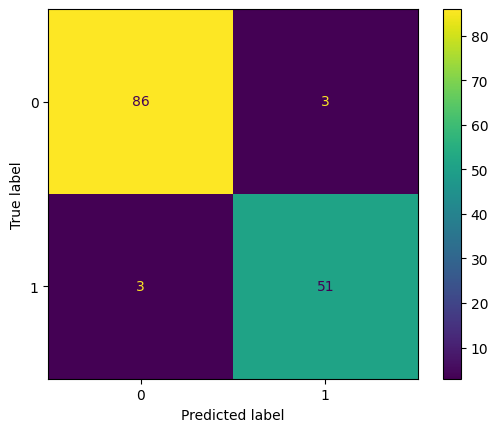

In [26]:
cf_matrix_rf = confusion_matrix(y_test,pred_rf_1, labels=rf_model_1.classes_)
ConfusionMatrixDisplay(confusion_matrix=cf_matrix_rf,
                       display_labels=rf_model_1.classes_).plot()

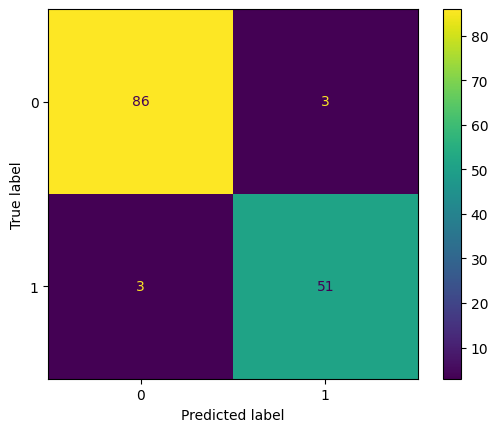

In [27]:
cf_matrix_rf = confusion_matrix(y_test,pred_rf_2, labels=rf_model_2.classes_)
ConfusionMatrixDisplay(confusion_matrix=cf_matrix_rf,
                       display_labels=rf_model_2.classes_).plot()

# Interpretação dos Resultados:

- Precision (Precisão): Mede a proporção de diagnósticos malignos preditos corretamente em relação ao total de predições malignas. Valores altos (0.97 e 0.94) indicam que os falsos positivos foram mínimos.

- Recall (Sensibilidade): Indica a capacidade do modelo de identificar corretamente os casos malignos (verdadeiros positivos). Valores de 0.97 e 0.94 mostram que o modelo é altamente eficaz em detectar câncer maligno.

- F1-Score: É a média harmônica entre precisão e recall. Um F1-score de 0.96 em ambos os modelos indica um equilíbrio sólido entre esses dois aspectos.

# Matriz de Confusão 

- A atriz de confusão é uma ferramenta visual que resume o desempenho de um modelo de classificação. Ela mostra o número de verdadeiros positivos (VP), verdadeiros negativos (VN), falsos positivos (FP) e falsos negativos (FN) para cada classe. Nesse caso, o modelo errou 3 vezes sendo maligno e benigno. Acertou 83 vezes sendo Benigno e 51 vezes sendo maligno.

# Curva ROC

- A curva ROC (Receiver Operating Characteristic) é uma representação gráfica que mostra a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR) para diferentes limiares de classificação. A área sob a curva (AUC) é uma métrica que resume a capacidade do modelo em distinguir entre as classes. Um AUC de 0.96 indica que o modelo tem um desempenho muito bom na classificação. Esse modelo é altamente eficaz em distinguir entre câncer maligno e benigno, pois sua curva roc é de 0.98.

# RESUMO:

- O modelo é altamente eficaz, é bom e é preciso. 